In [ ]:
pip install xgboost==1.7.3 scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.37.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
#Set Display Options
np.set_printoptions(precision=3)
pd.options.display.precision = 3

In [ ]:
# Uploads a file via Google Colab's interface and loads the first uploaded Excel file into a Pandas DataFrame.
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
mpg = pd.read_excel(file_name)

Saving mpg.data.xlsx to mpg.data.xlsx


In [ ]:
# Removes unnecessary columns, and renames misspelled columns
mpg.drop(columns=['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], errors='ignore', inplace=True)
mpg.rename(columns={'displayments': 'displacement'}, inplace=True)


In [ ]:
# Converts model year to a four-digit format
mpg['model_year_full'] = mpg['model year'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)
mpg['model year'] = mpg['model_year_full']
mpg.drop('model_year_full', axis=1, inplace=True)

In [ ]:
# Handles missing values by dropping or imputing with median values
mpg.dropna(subset=["mpg"], inplace=True)
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())


In [ ]:
# Ensures displacement and horsepower are integers
mpg[['displacement', 'horsepower']] = mpg[['displacement', 'horsepower']].astype(int)


In [ ]:
# Extracts brand names from car model descriptions and corrects inconsistencies
mpg[['brand', 'model']] = mpg['car name'].str.split(' ', n=1, expand=True)
mpg.drop(columns=['car name', 'model'], inplace=True)


brand_corrections = {
    "vw": "volkswagen", "maxda": "mazda", "chevroelt": "chevrolet",
    "chevy": "chevrolet", "toyouta": "toyota", "mercedes": "mercedes-benz",
    "vokswagen": "volkswagen", "capri": "ford", "mercury": "ford",
    "triumph": "bmw", "plymouth": "chrysler"
}
mpg["brand"] = mpg["brand"].replace(brand_corrections)

In [ ]:
# We Encoded top brands while grouping others under 'other'
top_brands = mpg["brand"].value_counts().nlargest(5).index
mpg_encoded = pd.get_dummies(mpg["brand"].where(mpg["brand"].isin(top_brands), "other"))
mpg = pd.concat([mpg, mpg_encoded], axis=1)
mpg.drop('brand', axis=1, inplace=True)

In [ ]:
# Categorizes fuel efficiency into three levels(1,2,3 (1 being the highest))
min_mpg, max_mpg = mpg['mpg'].min(), mpg['mpg'].max()
thresholds = [min_mpg + (max_mpg - min_mpg) * i / 3 for i in (1, 2)]
mpg['efficiency'] = pd.cut(mpg['mpg'], bins=[float('-inf')] + thresholds + [float('inf')], labels=[2, 1, 0], include_lowest=True)


In [ ]:
# Drops mpg column after classification
mpg.drop('mpg', axis=1, inplace=True)

In [ ]:
# Encodes target variable numerically
label_encoder = LabelEncoder()
mpg['efficiency'] = label_encoder.fit_transform(mpg['efficiency'])


In [ ]:
# Splits dataset into training and testing sets
X = mpg.drop(columns=['efficiency'])
y = mpg['efficiency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Trains XGBoost classifier with specified hyperparameters for more balanced results
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# Evaluates model on test data
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.92      0.85      0.88        39
           2       0.87      1.00      0.93        33

    accuracy                           0.89        80
   macro avg       0.87      0.82      0.84        80
weighted avg       0.89      0.89      0.88        80



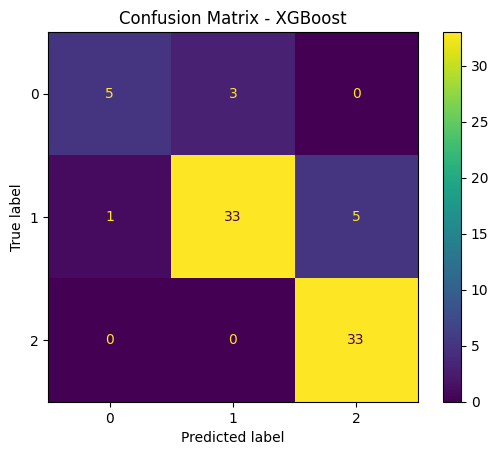

In [ ]:
# Displays confusion matrix for model performance
cm_display = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()